JAX backend: cpu
Devices available: [CpuDevice(id=0)]
Loading MNIST dataset...
Training images shape: (60000, 28, 28, 1)
Training labels shape: (60000, 10)
Test images shape: (10000, 28, 28, 1)
Test labels shape: (10000, 10)

Starting training for 5 epochs...
Batch size: 128, Steps per epoch: 468


Epoch 1/5:   0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 1 Summary: 
  Train Loss: 0.2030, Train Accuracy: 0.9412
  Test Loss:  0.0663, Test Accuracy:  0.9796



Epoch 2/5:   0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 2 Summary: 
  Train Loss: 0.0582, Train Accuracy: 0.9826
  Test Loss:  0.0407, Test Accuracy:  0.9863



Epoch 3/5:   0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 3 Summary: 
  Train Loss: 0.0417, Train Accuracy: 0.9873
  Test Loss:  0.0357, Test Accuracy:  0.9879



Epoch 4/5:   0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 4 Summary: 
  Train Loss: 0.0326, Train Accuracy: 0.9902
  Test Loss:  0.0290, Test Accuracy:  0.9902



Epoch 5/5:   0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 5 Summary: 
  Train Loss: 0.0262, Train Accuracy: 0.9921
  Test Loss:  0.0271, Test Accuracy:  0.9914

Training finished.


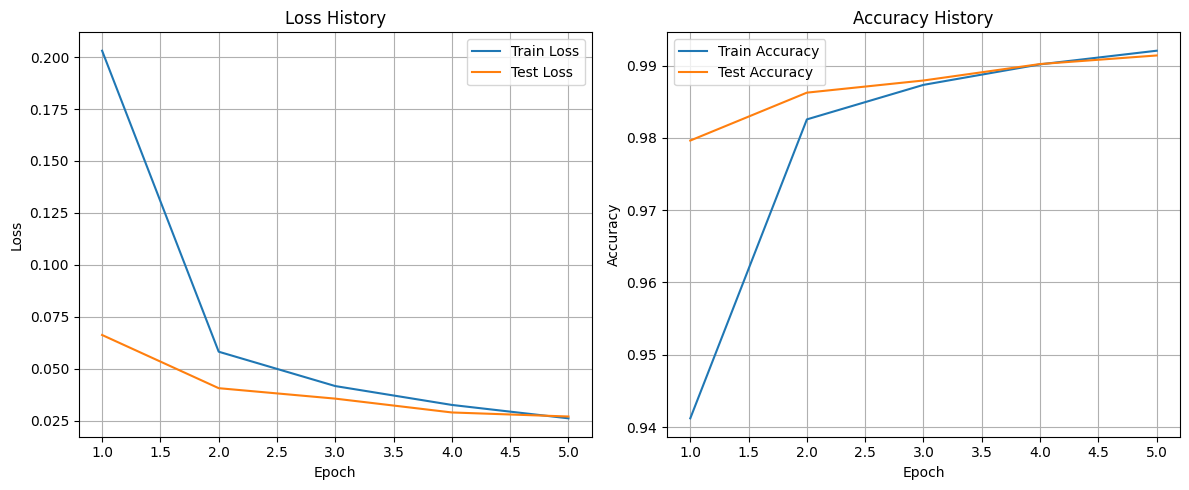

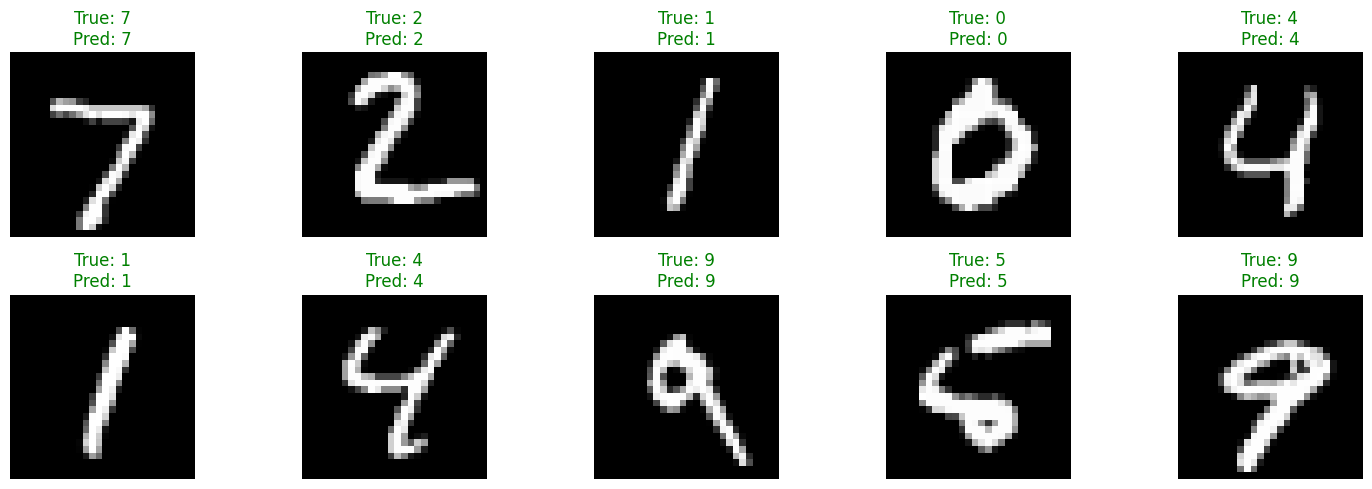

In [1]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import flax.linen as nn  # Flax neural network layers
import optax  # Optimizers for JAX
from datasets import load_dataset # To load MNIST easily
import numpy as np  # Standard numpy for data manipulation
from tqdm.notebook import tqdm # Progress bar (use 'tqdm' if not in notebook)
import matplotlib.pyplot as plt
from flax.training import train_state # Helper for managing model state

print(f"JAX backend: {jax.default_backend()}")
print(f"Devices available: {jax.devices()}")

# 1. Define the CNN Model using Flax
class CNN(nn.Module):
    num_classes: int = 10 # MNIST has 10 classes (digits 0-9)

    @nn.compact # Decorator for concise layer definition
    def __call__(self, x, training: bool):
        # Input shape: (batch_size, 28, 28, 1)

        # Add channel dimension if it's missing (e.g., input is B, H, W)
        if x.ndim == 3:
            x = jnp.expand_dims(x, axis=-1)

        # First Convolutional Block
        x = nn.Conv(features=32, kernel_size=(3, 3))(x) # Output: (B, 26, 26, 32)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2)) # Output: (B, 13, 13, 32)

        # Second Convolutional Block
        x = nn.Conv(features=64, kernel_size=(3, 3))(x) # Output: (B, 11, 11, 64)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2)) # Output: (B, 5, 5, 64)

        # Flatten the output for the Dense layers
        x = x.reshape((x.shape[0], -1)) # Flatten to (B, 5*5*64) = (B, 1600)

        # Dense Layers
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        # Dropout during training for regularization
        if training:
             # Note: Use deterministic=False for training, True for eval
             # Requires passing a PRNG key to the apply function during training
             # Simpler approach here: only apply dense layers without dropout
             # For dropout, you'd need to manage PRNG keys carefully in train_step
             pass # We'll omit dropout for simplicity here

        x = nn.Dense(features=self.num_classes)(x)
        # No final activation here, as cross-entropy loss often takes logits

        return x

# 2. Load and Preprocess MNIST Data
def preprocess_mnist():
    print("Loading MNIST dataset...")
    ds = load_dataset("mnist")
    ds.set_format(type='numpy') # Ensure data is numpy array

    # --- Training Data ---
    train_images = ds['train']['image']
    train_labels = ds['train']['label']
    # Normalize pixel values to [0, 1]
    train_images = train_images.astype(np.float32) / 255.0
    # Add channel dimension: (60000, 28, 28) -> (60000, 28, 28, 1)
    # Flax Conv expects NHWC (Batch, Height, Width, Channels) by default
    train_images = np.expand_dims(train_images, axis=-1)
    # One-hot encode labels
    train_labels_one_hot = jax.nn.one_hot(train_labels, num_classes=10)
    print(f"Training images shape: {train_images.shape}")
    print(f"Training labels shape: {train_labels_one_hot.shape}")


    # --- Test Data ---
    test_images = ds['test']['image']
    test_labels = ds['test']['label']
    # Normalize
    test_images = test_images.astype(np.float32) / 255.0
    # Add channel dimension
    test_images = np.expand_dims(test_images, axis=-1)
    # One-hot encode labels (optional for evaluation, can compare argmax directly)
    test_labels_one_hot = jax.nn.one_hot(test_labels, num_classes=10)
    print(f"Test images shape: {test_images.shape}")
    print(f"Test labels shape: {test_labels_one_hot.shape}")


    return train_images, train_labels_one_hot, test_images, test_labels_one_hot, test_labels

train_images, train_labels, test_images, test_labels_one_hot, test_labels_raw = preprocess_mnist()

# 3. Define Training Step and Loss
# We use optax's cross entropy function which expects logits
def cross_entropy_loss(logits, labels):
    # logits: (batch_size, num_classes), output of the model
    # labels: (batch_size, num_classes), one-hot encoded true labels
    return -jnp.sum(labels * jax.nn.log_softmax(logits), axis=-1)

def compute_metrics(logits, labels):
    loss = jnp.mean(cross_entropy_loss(logits, labels))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(labels, -1))
    metrics = {
        'loss': loss,
        'accuracy': accuracy
    }
    return metrics

# Use JIT compilation for performance
@jit
def train_step(state, batch_images, batch_labels):
    """Performs a single training step."""
    # Define a function that calculates loss and gradients
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch_images, training=True) # Pass training=True
        loss = jnp.mean(cross_entropy_loss(logits, batch_labels))
        return loss, logits

    # Compute gradients using jax.grad, also get loss and logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)

    # Update model parameters using the optimizer
    state = state.apply_gradients(grads=grads)

    # Compute metrics for logging
    metrics = compute_metrics(logits, batch_labels)
    return state, metrics

@jit
def eval_step(state, batch_images, batch_labels):
    """Performs evaluation on a batch."""
    # Get model predictions (logits) - note training=False
    logits = state.apply_fn({'params': state.params}, batch_images, training=False)
    return compute_metrics(logits, batch_labels)


# 4. Initialize Model and Optimizer

# PRNG Key for initialization
key = random.PRNGKey(0)
model = CNN()

# Input shape for initialization (batch_size, height, width, channels)
# Use a dummy input with batch size 1
dummy_input = jnp.ones([1, 28, 28, 1])

# Initialize parameters
# variables is a dict containing 'params'
variables = model.init(key, dummy_input, training=False) # Initialize in eval mode
params = variables['params'] # Extract the actual parameters

# Define Optimizer (Adam is a good default)
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)

# Create a TrainState object to manage parameters, optimizer state, etc.
# It bundles the model's apply function, parameters, and optimizer state
state = train_state.TrainState.create(
    apply_fn=model.apply, params=params, tx=optimizer
)
# Clean up large variables if needed
# del params
# del variables

# 5. Training Loop
num_epochs = 5
batch_size = 128
num_train_steps = len(train_images) // batch_size

print(f"\nStarting training for {num_epochs} epochs...")
print(f"Batch size: {batch_size}, Steps per epoch: {num_train_steps}")

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Use a separate key for shuffling data each epoch
shuffle_key = random.PRNGKey(1)

for epoch in range(num_epochs):
    # Shuffle training data
    shuffle_key, subkey = random.split(shuffle_key)
    perm = random.permutation(subkey, len(train_images))
    epoch_train_images = train_images[perm]
    epoch_train_labels = train_labels[perm]

    batch_metrics = []
    # Use tqdm for progress bar
    with tqdm(range(num_train_steps), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
        for step in pbar:
            # Create batches
            start_idx = step * batch_size
            end_idx = start_idx + batch_size
            batch_images = epoch_train_images[start_idx:end_idx]
            batch_labels = epoch_train_labels[start_idx:end_idx]

            # Perform one training step
            state, metrics = train_step(state, batch_images, batch_labels)
            batch_metrics.append(metrics)

            # Update progress bar postfix
            pbar.set_postfix(loss=f"{metrics['loss']:.4f}", acc=f"{metrics['accuracy']:.4f}")

    # --- Epoch End: Calculate Average Training Metrics ---
    # Aggregate metrics from all batches in the epoch
    epoch_train_summary = {
        m: np.mean([metrics[m] for metrics in batch_metrics])
        for m in batch_metrics[0] # Get keys from the first metric dict
    }
    train_losses.append(epoch_train_summary['loss'])
    train_accuracies.append(epoch_train_summary['accuracy'])

    # --- Epoch End: Evaluate on Test Set ---
    test_batch_metrics = []
    num_test_steps = len(test_images) // batch_size
    if len(test_images) % batch_size != 0: num_test_steps += 1 # Handle leftover batch

    for i in range(num_test_steps):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(test_images)) # Avoid going past the end
        if start_idx == end_idx: continue # Skip if batch is empty

        test_batch_images = test_images[start_idx:end_idx]
        test_batch_labels = test_labels_one_hot[start_idx:end_idx]

        metrics = eval_step(state, test_batch_images, test_batch_labels)
        test_batch_metrics.append(metrics)

    epoch_test_summary = {
        m: np.mean([metrics[m] for metrics in test_batch_metrics])
        for m in test_batch_metrics[0]
    }
    test_losses.append(epoch_test_summary['loss'])
    test_accuracies.append(epoch_test_summary['accuracy'])

    print(f"Epoch {epoch + 1} Summary: ")
    print(f"  Train Loss: {epoch_train_summary['loss']:.4f}, Train Accuracy: {epoch_train_summary['accuracy']:.4f}")
    print(f"  Test Loss:  {epoch_test_summary['loss']:.4f}, Test Accuracy:  {epoch_test_summary['accuracy']:.4f}\n")


print("Training finished.")

# 6. Plot Training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy History')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 7. Visualize Some Predictions
def predict(state, images):
    """Get predictions for a batch of images."""
    logits = state.apply_fn({'params': state.params}, images, training=False)
    return jnp.argmax(logits, axis=-1)

# Get predictions for the first few test images
num_visualize = 10
sample_images = test_images[:num_visualize]
sample_labels = test_labels_raw[:num_visualize] # Use raw labels (0-9)
predictions = predict(state, sample_images)

# Ensure predictions are on CPU as numpy arrays for plotting
predictions = np.array(predictions)

plt.figure(figsize=(15, 5))
for i in range(num_visualize):
    plt.subplot(2, 5, i + 1)
    # Reshape image from (28, 28, 1) to (28, 28) for imshow
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.title(f"True: {sample_labels[i]}\nPred: {predictions[i]}",
              color=("green" if predictions[i] == sample_labels[i] else "red"))
    plt.axis('off')
plt.tight_layout()
plt.show()